In [ ]:
import numpy as np
import sklearn
import pandas as pd
import io
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import files
import nltk
from nltk.corpus import stopwords
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
drive.mount('/content/drive', force_remount = True)
path = "/content/drive/MyDrive/Dataset Research Method/clickbait.csv" # Drive Tootnoot
df = pd.read_csv(path)

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')
df['title_without_stopwords'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in(stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
le = LabelEncoder()
le.fit(df['label'])
df['label_encoded'] = le.transform(df['label'])

In [ ]:
texts = df.title_without_stopwords # Your text data
labels = df.label_encoded # Your binary labels
max_words = 1000 # Maximum number of words to keep based on word frequency
max_len = 100 # Maximum length of sequences

In [ ]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen = max_len)
y = np.asarray(labels)

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 50, input_length = max_len))
model.add(LSTM(units = 32, dropout = 0.4))
model.add(Dense(units = 1, activation = 'sigmoid'))
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
def plot_graphs(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
filepath = "/content/drive/MyDrive/Dataset Research Method/modelcheckpoint.h5"
model_checkpoint = ModelCheckpoint(filepath, monitor = "val_accuracy", varbose = 1, save_best_only = True, mode = "max")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [ ]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(y_pred_binary)

100/100 [==============================] - 0s 3ms/step
[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]


In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks = [early_stop, model_checkpoint])

Epoch 1/10
800/800 [==============================] - 24s 25ms/step - loss: 0.1251 - accuracy: 0.9481 - val_loss: 0.0640 - val_accuracy: 0.9791
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.0533 - accuracy: 0.9824 - val_loss: 0.0691 - val_accuracy: 0.9766
Epoch 3/10
800/800 [==============================] - 6s 7ms/step - loss: 0.0469 - accuracy: 0.9845 - val_loss: 0.0666 - val_accuracy: 0.9775
Epoch 4/10
800/800 [==============================] - 6s 8ms/step - loss: 0.0431 - accuracy: 0.9852 - val_loss: 0.0716 - val_accuracy: 0.9753
Epoch 5/10
800/800 [==============================] - 7s 8ms/step - loss: 0.0405 - accuracy: 0.9868 - val_loss: 0.0679 - val_accuracy: 0.9787
Epoch 6/10
800/800 [==============================] - 7s 8ms/step - loss: 0.0373 - accuracy: 0.9877 - val_loss: 0.0677 - val_accuracy: 0.9787


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

100/100 [==============================] - 0s 5ms/step - loss: 0.0514 - accuracy: 0.9794
Test accuracy: 0.9793685674667358
Test loss: 0.051412127912044525


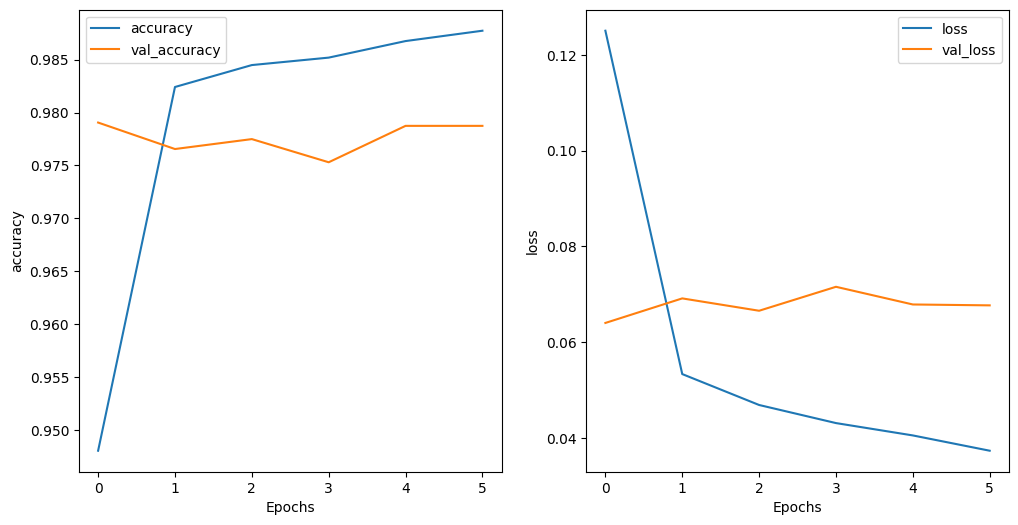

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.savefig('plot.png')
plt.show()

[[1555   42]
 [  24 1578]]


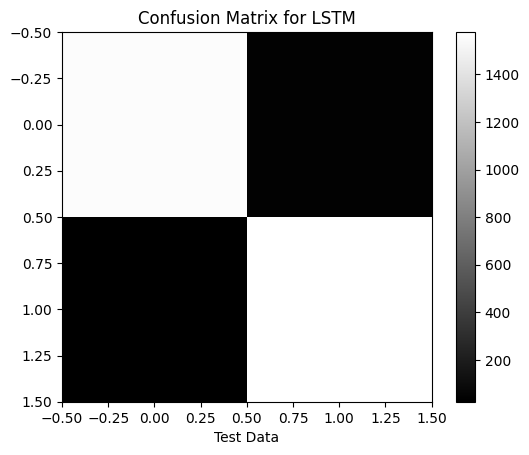

In [ ]:
cm = confusion_matrix(y_test, y_pred_binary)
plt.imshow(cm, cmap = plt.cm.gray)
plt.title("Confusion Matrix for LSTM")
plt.colorbar()
plt.xlabel("Prediction Data")
plt.xlabel("Test Data")
print(cm)

In [ ]:
target = ('0', '1')
print(classification_report(y_test, y_pred_binary, target_names=target, digits = 5))

              precision    recall  f1-score   support

           0    0.10490   0.00939   0.01724      1597
           1    0.48233   0.92010   0.63289      1602

    accuracy                        0.46546      3199
   macro avg    0.29361   0.46475   0.32507      3199
weighted avg    0.29391   0.46546   0.32555      3199

